<a href="https://colab.research.google.com/github/sureshkuc/Freie-Universitat-Berlin/blob/main/GEOMETRIC-DATA-ANALYSIS/DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-cluster
!pip install torch-geometric

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os.path as osp

import torch
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphConv, TopKPooling,GCNConv
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_mean_pool as gap

dataset = TUDataset(root='/tmp/DD', name='DD')
dataset = dataset.shuffle()
n = len(dataset) // 10
test_dataset = dataset[:n]
train_dataset = dataset[n:]
test_loader = DataLoader(test_dataset, batch_size=32)
train_loader = DataLoader(train_dataset, batch_size=32)


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = GCNConv(dataset.num_features, 64)
        self.pool1 = TopKPooling(64, ratio=0.8)
        self.conv2 = GCNConv(64, 64)
        self.pool2 = TopKPooling(64, ratio=0.8)
        self.conv3 = GCNConv(64, 64)
        self.pool3 = TopKPooling(64, ratio=0.8)
        self.lin_skip1 = torch.nn.Linear(dataset.num_features, 64)
        self.lin_skip2 = torch.nn.Linear(64,64)
        self.lin_skip3 = torch.nn.Linear(64, 64)
        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index)+self.lin_skip1(x))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index)+self.lin_skip2(x))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index)+self.lin_skip3(x))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


def train(epoch):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

train_acc_list=[]
test_acc_list=[]
for epoch in range(1, 20):
    loss = train(epoch)
    train_acc = test(train_loader)
    train_acc_list.append(train_acc )
    test_acc = test(test_loader)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.5f}, Train Acc: {train_acc:.5f}, '
          f'Test Acc: {test_acc:.5f}')
def plot_acc(epochs,train_losses,test_losses):
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.rcParams['figure.dpi'] = 100
  plt.plot(range(epochs),train_losses, label='train acc')
  plt.plot(range(epochs),test_losses,label='test acc')
  plt.title('Sparse Hierarchical Graph Classifier')
  plt.legend()
  plt.show()


Extracting /tmp/DD/DD/DD.zip
Processing...
Done!


Epoch: 001, Loss: 0.68298, Train Acc: 0.58435, Test Acc: 0.60684
Epoch: 002, Loss: 0.67855, Train Acc: 0.58435, Test Acc: 0.60684
Epoch: 003, Loss: 0.67661, Train Acc: 0.58435, Test Acc: 0.60684
Epoch: 004, Loss: 0.67490, Train Acc: 0.58435, Test Acc: 0.60684
Epoch: 005, Loss: 0.67128, Train Acc: 0.58435, Test Acc: 0.60684
Epoch: 006, Loss: 0.66396, Train Acc: 0.58435, Test Acc: 0.60684
Epoch: 007, Loss: 0.64041, Train Acc: 0.59755, Test Acc: 0.61538
Epoch: 008, Loss: 0.60813, Train Acc: 0.67389, Test Acc: 0.70940
Epoch: 009, Loss: 0.57114, Train Acc: 0.75118, Test Acc: 0.72650
Epoch: 010, Loss: 0.54103, Train Acc: 0.77003, Test Acc: 0.72650
Epoch: 011, Loss: 0.52160, Train Acc: 0.77003, Test Acc: 0.71795
Epoch: 012, Loss: 0.51486, Train Acc: 0.77191, Test Acc: 0.73504
Epoch: 013, Loss: 0.49685, Train Acc: 0.77003, Test Acc: 0.72650
Epoch: 014, Loss: 0.48487, Train Acc: 0.75966, Test Acc: 0.72650
Epoch: 015, Loss: 0.48311, Train Acc: 0.76249, Test Acc: 0.72650
Epoch: 016, Loss: 0.46066

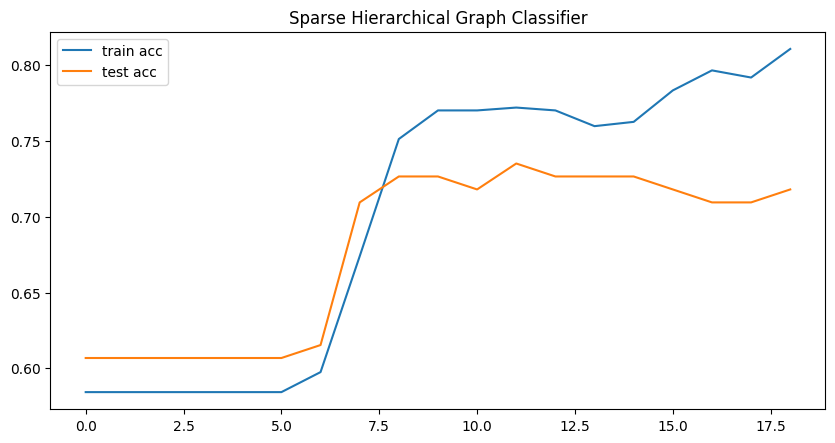

In [4]:
plot_acc(19,train_acc_list,test_acc_list)

In [ ]:
from sklearn.model_selection import KFold
def train(epoch,train_loader):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)
dataset = TUDataset(root='/tmp/DD', name='DD')
dataset = dataset.shuffle()
batch_size=32
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print(train_idx)
    print('Fold {}'.format(fold + 1))
    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
    test_dataset = dataset[val_idx]
    print(test_dataset)
    train_dataset = dataset[train_idx]
    test_loader = DataLoader(test_dataset, batch_size=60)
    train_loader = DataLoader(train_dataset, batch_size=60)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    for epoch in range(1, 20):
      loss = train(epoch,train_loader)
      train_acc = test(train_loader)
      #train_acc_list.append(train_acc )
      test_acc = test(test_loader)
      #test_acc_list.append(test_acc)
      print(f'Epoch: {epoch:03d}, Loss: {loss:.5f}, Train Acc: {train_acc:.5f}, '
            f'Test Acc: {test_acc:.5f}')
      history['train_loss'].append(loss)
      #history['test_loss'].append(test_loss)
      history['train_acc'].append(train_acc)
      history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history 

[   0    1    2 ... 1174 1175 1176]
Fold 1
DD(118)
Epoch: 001, Loss: 0.68688, Train Acc: 0.58868, Test Acc: 0.56780
Epoch: 002, Loss: 0.67654, Train Acc: 0.58868, Test Acc: 0.56780
Epoch: 003, Loss: 0.67437, Train Acc: 0.58868, Test Acc: 0.56780
Epoch: 004, Loss: 0.67085, Train Acc: 0.58868, Test Acc: 0.56780
Epoch: 005, Loss: 0.66730, Train Acc: 0.58868, Test Acc: 0.56780
Epoch: 006, Loss: 0.66178, Train Acc: 0.58868, Test Acc: 0.56780
Epoch: 007, Loss: 0.64908, Train Acc: 0.58868, Test Acc: 0.56780
Epoch: 008, Loss: 0.63928, Train Acc: 0.63113, Test Acc: 0.57627
Epoch: 009, Loss: 0.61990, Train Acc: 0.71509, Test Acc: 0.66949
Epoch: 010, Loss: 0.59691, Train Acc: 0.73019, Test Acc: 0.69492
Epoch: 011, Loss: 0.57753, Train Acc: 0.74340, Test Acc: 0.72881
Epoch: 012, Loss: 0.56458, Train Acc: 0.75660, Test Acc: 0.72881
Epoch: 013, Loss: 0.54556, Train Acc: 0.75755, Test Acc: 0.73729
Epoch: 014, Loss: 0.52975, Train Acc: 0.76792, Test Acc: 0.73729
Epoch: 015, Loss: 0.51209, Train Acc: 0

In [ ]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     #testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.4f}".format(np.mean(tl_f),np.mean(ta_f),np.mean(testa_f)))